- BatchNormalization
- Resnet, Senet
- Hyperparameter Tuning
- retrain different layers
- mixed precision tests

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.keras.__version__)
print(tf.__version__)
tf.config.list_physical_devices('GPU')
#keras.mixed_precision.set_global_policy("mixed_float16") # turn on mixed precision for faster computation

2.12.0
2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'
#train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/train_set'
#test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/val_set'

In [3]:
import random

def load_data(train_img_dir, test_img_dir, image_size=(224,224), batch_size=32, validation_split=0.2):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=validation_split,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [5]:
import numpy as np

classes = {0: 'neutral', 
           1: 'happiness', 
           2: 'sadness', 
           3: 'surprise', 
           4: 'fear', 
           5: 'disgust', 
           6: 'anger', 
           7: 'contempt'}

# calculate weights on class distribution from 0-7
total_images = 287_652
images_per_class = [74_874, 134_415, 25_459, 14_090, 6_378, 3_803, 24_882, 3_750]
class_distribution = [d/total_images for d in images_per_class]
# inverse class distribution for weights (lower dist = higher weight)
class_weights = [1.0 / dist for dist in class_distribution]
# normalize
class_weights_normalized = class_weights / np.sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_normalized)}
class_weights_dict

{0: 0.01557266066902349,
 1: 0.008674533310511956,
 2: 0.045798632897304084,
 3: 0.08275283143594497,
 4: 0.18281395342308948,
 5: 0.3065967380837404,
 6: 0.04686067819839501,
 7: 0.31092997198199057}

---

---

In [7]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_vggface-resnet50_finetuned_"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name + 'E{epoch:02d}-VLoss{val_loss:.2f}.keras',
        save_best_only=False,
        save_freq='epoch',
        monitor="val_loss",
        verbose=1),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=20),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-8)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230714_21-50_fer_vggface-resnet50_finetuned_
Epoch 1/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.4915
Epoch 1: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E01-VLoss1.07.keras
7192/7192 [==============================] - 540s 74ms/step - loss: 0.0491 - accuracy: 0.4915 - val_loss: 1.0703 - val_accuracy: 0.6139 - lr: 0.0010
Epoch 2/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.5349
Epoch 2: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E02-VLoss0.96.keras
7192/7192 [==============================] - 528s 73ms/step - loss: 0.0435 - accuracy: 0.5349 - val_loss: 0.9631 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 3/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.5450
Epoch 3: sa

Epoch 24/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.5986
Epoch 24: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E24-VLoss0.97.keras
7192/7192 [==============================] - 528s 73ms/step - loss: 0.0340 - accuracy: 0.5986 - val_loss: 0.9665 - val_accuracy: 0.6190 - lr: 8.0000e-06
Epoch 25/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.5978
Epoch 25: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E25-VLoss0.97.keras

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
7192/7192 [==============================] - 527s 73ms/step - loss: 0.0339 - accuracy: 0.5978 - val_loss: 0.9672 - val_accuracy: 0.6186 - lr: 8.0000e-06


In [8]:
model = history.model
#print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 6s 44ms/step - loss: 1.1821 - accuracy: 0.5889
Test accuracy: 0.589


In [31]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E11-VLoss0.99.keras')
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230714_21-50_fer_vggface-resnet50_finetuned_
125/125 [==============================] - 5s 41ms/step - loss: 1.1506 - accuracy: 0.5886
Test accuracy: 0.589


In [19]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E21-VLoss0.97.keras')
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230714_21-50_fer_vggface-resnet50_finetuned_
125/125 [==============================] - 5s 40ms/step - loss: 1.1677 - accuracy: 0.5916
Test accuracy: 0.592


## #1 Best Model so far

In [25]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E16-VLoss0.99.keras')
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230714_21-50_fer_vggface-resnet50_finetuned_
125/125 [==============================] - 5s 40ms/step - loss: 1.1595 - accuracy: 0.5926
Test accuracy: 0.593


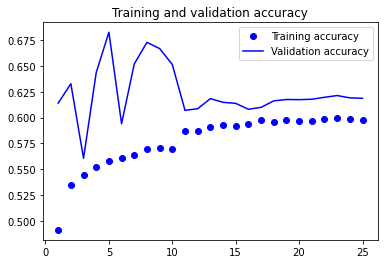

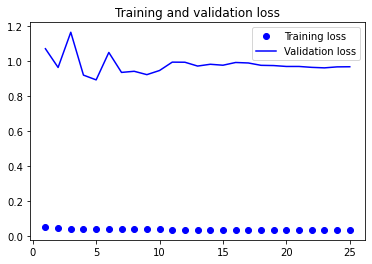

In [9]:
plot_history(history)

---

---

In [9]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E05-VLoss0.89.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 30ms/step - loss: 1.3543 - accuracy: 0.5279
Test accuracy: 0.528


In [13]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E25-VLoss0.97.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 30ms/step - loss: 1.1821 - accuracy: 0.5891
Test accuracy: 0.589


In [14]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E09-VLoss0.92.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 30ms/step - loss: 1.4456 - accuracy: 0.5201
Test accuracy: 0.520


In [15]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E10-VLoss0.95.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 30ms/step - loss: 1.5768 - accuracy: 0.5294
Test accuracy: 0.529


In [17]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E15-VLoss0.98.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 31ms/step - loss: 1.1660 - accuracy: 0.5884
Test accuracy: 0.588


In [16]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E16-VLoss0.99.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 31ms/step - loss: 1.1595 - accuracy: 0.5926
Test accuracy: 0.593


In [18]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E17-VLoss0.99.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 31ms/step - loss: 1.1598 - accuracy: 0.5904
Test accuracy: 0.590


In [19]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E24-VLoss0.97.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 31ms/step - loss: 1.1714 - accuracy: 0.5891
Test accuracy: 0.589


In [8]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E16-VLoss0.99.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 6s 34ms/step - loss: 1.8172 - accuracy: 0.3798
Test accuracy: 0.380


In [9]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E25-VLoss0.97.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 31ms/step - loss: 1.8285 - accuracy: 0.3808
Test accuracy: 0.381


---

# Train Occluded Images 224x224

In [10]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

train_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/val_set'

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_vggface-resnet50_finetuned_"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name + 'E{epoch:02d}-VLoss{val_loss:.2f}.keras',
        save_best_only=False,
        save_freq='epoch',
        monitor="val_loss",
        verbose=1),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=20),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-8)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230919_19-18_fer_vggface-resnet50_finetuned_
Epoch 1/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.4226
Epoch 1: saving model to 20230919_19-18_fer_vggface-resnet50_finetuned_E01-VLoss1.30.keras
7192/7192 [==============================] - 386s 53ms/step - loss: 0.0568 - accuracy: 0.4226 - val_loss: 1.2970 - val_accuracy: 0.4807 - lr: 0.0010
Epoch 2/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.4567
Epoch 2: saving model to 20230919_19-18_fer_vggface-resnet50_finetuned_E02-VLoss1.28.keras
7192/7192 [==============================] - 381s 53ms/step - loss: 0.0528 - accuracy: 0.4567 - val_loss: 1.2784 - val_accuracy: 0.4934 - lr: 0.0010
Epoch 3/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.4655
Epoch 3: sa

In [11]:
model = history.model
#print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 30ms/step - loss: 1.3890 - accuracy: 0.4964
Test accuracy: 0.496


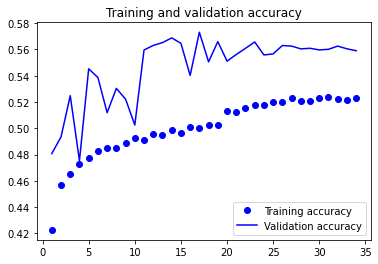

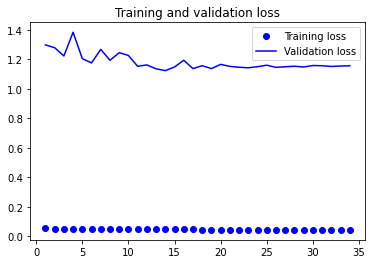

In [12]:
plot_history(history)

In [13]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = history.model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 30ms/step - loss: 1.5414 - accuracy: 0.4721
Test accuracy: 0.472


In [14]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = keras.models.load_model('20230919_19-18_fer_vggface-resnet50_finetuned_E14-VLoss1.12.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 30ms/step - loss: 1.4647 - accuracy: 0.4639
Test accuracy: 0.464


In [15]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = keras.models.load_model('20230919_19-18_fer_vggface-resnet50_finetuned_E14-VLoss1.12.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 31ms/step - loss: 1.5156 - accuracy: 0.4469
Test accuracy: 0.447


# Train 50% Occluded Images 224x224

In [6]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

train_img_dir = '/home/lndr/Development/FER/AffectNet_50percent_occluded/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_50percent_occluded/val_set'

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_vggface-resnet50_finetuned_"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name + 'E{epoch:02d}-VLoss{val_loss:.2f}.keras',
        save_best_only=False,
        save_freq='epoch',
        monitor="val_loss",
        verbose=1),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=20),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-8)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230920_23-07_fer_vggface-resnet50_finetuned_
Epoch 1/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.4449
Epoch 1: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E01-VLoss1.56.keras
7192/7192 [==============================] - 437s 60ms/step - loss: 0.0541 - accuracy: 0.4449 - val_loss: 1.5585 - val_accuracy: 0.3835 - lr: 0.0010
Epoch 2/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.4844
Epoch 2: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E02-VLoss2.08.keras
7192/7192 [==============================] - 404s 56ms/step - loss: 0.0493 - accuracy: 0.4844 - val_loss: 2.0762 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 3/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.4968
Epoch 3: sa

Epoch 24/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.5531
Epoch 24: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E24-VLoss1.09.keras
7192/7192 [==============================] - 380s 53ms/step - loss: 0.0395 - accuracy: 0.5531 - val_loss: 1.0857 - val_accuracy: 0.5783 - lr: 4.0000e-05
Epoch 25/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.5507
Epoch 25: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E25-VLoss1.06.keras
7192/7192 [==============================] - 396s 55ms/step - loss: 0.0396 - accuracy: 0.5507 - val_loss: 1.0641 - val_accuracy: 0.5863 - lr: 4.0000e-05
Epoch 26/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.5516
Epoch 26: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E26-VLoss1.07.keras
7192/7192 [==============================] - 402s 56ms/step - loss: 0.0392 - accuracy: 0.5516 - val_loss: 1.0673 - val_ac

7192/7192 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.5553
Epoch 47: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E47-VLoss1.06.keras
7192/7192 [==============================] - 361s 50ms/step - loss: 0.0390 - accuracy: 0.5553 - val_loss: 1.0609 - val_accuracy: 0.5924 - lr: 3.2000e-07
Epoch 48/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.5570
Epoch 48: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E48-VLoss1.06.keras

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
7192/7192 [==============================] - 360s 50ms/step - loss: 0.0390 - accuracy: 0.5570 - val_loss: 1.0625 - val_accuracy: 0.5909 - lr: 3.2000e-07
Epoch 49/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.5548
Epoch 49: saving model to 20230920_23-07_fer_vggface-resnet50_finetuned_E49-VLoss1.06.keras
7192/7192 [==============================] - 362s 50ms/

In [7]:
model = history.model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 4s 33ms/step - loss: 1.3575 - accuracy: 0.5321
Test accuracy: 0.532


In [8]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_Occluded/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = history.model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 30ms/step - loss: 1.4359 - accuracy: 0.4804
Test accuracy: 0.480


In [9]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

model = history.model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 4s 30ms/step - loss: 1.2688 - accuracy: 0.5734
Test accuracy: 0.573
